<a href="https://colab.research.google.com/github/uomodellamansarda/Arduino/blob/master/Workout_Analyzer_Eng_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is made to analyze Pomodoro Techniques Logs and undersand how well Data Science with Python practice is going. 
Practice could be study, no profit project, work, even reading a data book.

The goal is to reach 10.000 hourse to be an expert. 
It's just a trivial proxy, but gives an idea and a direction and it's enough. 

The code is made to compare the efforts with a 3h daily ideal and costant practice. 

At the end of the code, after analyzed the past data as a report and feedback session, I made three estimation about the remaining time based on:

-Markov Inequality 

-Linear regression (I know that variables are not indipendently and identically distributed)

-Non Linear Regression using Prophet, an open source library developed by Facebook 

NOTE
If the time series is not stationary, or any of its possible trasformations you could not evaluate autocorrelation and partial correlation 

In the Year, Month, Week Analysis, I should create a logic that starts counting from the current day, instead at the moment it starts counting from the last log

#1 Library Setup


In [1]:
#Google Drive Pre-work
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
#importing all the necessary libraries 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import scipy.stats

#Autentication Section

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#DataLoading

In [4]:
#global variables of interest 

va='Python'
tvoi='Length'

#goal expressed in hours to be reached 
h=10000

#Link to the data source that is a csv file in drive
namepath="https://drive.google.com/file/d/1mbW7YyNbQV3M7LgTVxWeR_rt4tjA2PfZ/view?usp=sharing"
id=namepath.split('/')[-2]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  

# Dataset is now stored in a Pandas Dataframe
csvname="Filename.csv"
#read the csv
#The number of columns from the app csv file is known	
columns_name=['Year', 'Month', 'Day', 'Time', 'Length', 'Start', 'End', 'Activity']
dfraw=pd.read_csv(csvname,names=columns_name,sep=',',skiprows=1,skipfooter=0, index_col=False)
print("Printing the data type of the time variable:")
print(type(dfraw[tvoi].iloc[0]))
dfraw[tvoi] = dfraw[tvoi].astype('str')
#We throw away time variables longer than 6 characters
# 00:00:00 if there is any variable 
# longer should be an error
mask = (dfraw[tvoi].str.len() == 6) 
dfraw = dfraw.loc[mask]
#removing all the white spaces
dfraw[tvoi]=dfraw[tvoi].str.strip()
#Converting to datetime datatype the time column
dfraw[tvoi]=pd.to_datetime(dfraw[tvoi], format='%M:%S')
#Merging in one date thre columns containing
#Year Month Day Informations
dfraw['Date'] = dfraw.apply(lambda row: datetime(row['Year'], row['Month'], row['Day']), axis=1)

#The code extracts all the logs containing the Python
#or python word
pythondf=dfraw[(dfraw['Activity'].str.contains("Python",na=False)) | (dfraw['Activity'].str.contains("python",na=False))] 


1mbW7YyNbQV3M7LgTVxWeR_rt4tjA2PfZ
<class 'str'>


## Resampling

In [5]:
#We create a copy of 
#the dataframe containing only the 
#python records and
#we aggregate on daily basis 
tb_df=pythondf.copy()
tb_df=pythondf.groupby('Date').count()

rs_df=tb_df
#We resample the dataframe in order to have 
#a continues time series 
#with daily frequency
#we fill missing values with 0
rs_df=rs_df.resample('D').asfreq().fillna(0)
#divide by 2 because each pomodoro record lasts 25 minutes
#and we create a new column to keep track of that 
rs_df['Cum']=rs_df['Activity'].cumsum().divide(2)

rs_df['Costant_CUM']=3
rs_df['Costant_CUM']=rs_df['Costant_CUM'].cumsum()


#Hours Remaining to be an expert

In [6]:
#Max Hours 
max_hours=rs_df['Cum'][-1]
print("Total Hours until now",max_hours)
remaining_h=h-max_hours
print("Remaining hours to became an expert: \n",remaining_h)

Total Hours until now 2485.0
Remaining hours to became an expert: 
 7515.0


#Plotting Functions

In [7]:
#We create a function 
#in order to plot all the hours dedicated to the 
#Variable of Interest (in this specific case python)
#And we compare with the "hours per day  goal"

def practice_plot(df):
    def plotting(df):
        fig, ax= plt.subplots(figsize=(15,10))
        ax.plot(df.index,df['Cum'])
        ax.plot(df.index,df['Costant_CUM'],'g--')
        ax.tick_params(axis='x',rotation=90)
        ax.set(title='Total Hours Studying and Working With Python (%d H)'%(maxh))
        plt.show()
        return 
    
    if len(df)>180:
        maxh=df.Cum.max()
        maxc=df.Costant_CUM.max()
        print("Max Hours %d h"%maxh)

        delta=maxh-maxc
        print("Il differenziale assoluto è di %s ore"%delta)
    
        delta_mens=[-30,-90,-180]
        delta_mens_dic={"Mese":-30,"Trimestre":-90,"Semestre":-180}
        z=df['Cum'].iloc[-1]
        y=df['Costant_CUM'].iloc[-1]

        percentage_change=[(((z-y)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) 
                   for x in delta_mens]
        x_print=[print("\n La percentuale di cambiamento è di %s negli ultimi %s giorni "%(percentage_change[ii],delta_mens[ii])) for ii in [0,1,2]]
        plotting(df)
    elif len(df)>90:
        maxh=df.Cum.max()
        maxc=df.Costant_CUM.max()
        delta_mens=[-30,-90]
        delta_mens_dic={"Mese":-30,"Trimestre":-90}
        z=df['Cum'].iloc[-1]
        y=df['Costant_CUM'].iloc[-1]
        
        percentage_change=[(((z-y)/(df['Cum'].iloc[x]-df['Costant_CUM'].iloc[x]))*100).round(2) 
                   for x in delta_mens]
        x_print=[print("\n La percentuale di cambiamento è di %s negli ultimi %s giorni "%(percentage_change[ii],delta_mens[ii])) for ii in [0,1]]
        plotting(df)
        plotting(df)
    elif len(df)<90:
        maxh=df.Cum.max()
        maxc=df.Costant_CUM.max()
        plotting(df)
    
def m_practice_plot(df): 
    
    maxh=df.Cum.max()
    maxc=df.Costant_CUM.max()
    print("Max Hours %d h"%maxh)
    delta=maxh-maxc

    fig, ax= plt.subplots(figsize=(15,10))
    ax.plot(df.index,df['Cum'])
    ax.plot(df.index,df['Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Total Hours Studying and Working With Python (%d H)'%(maxh))
    
    plt.show()
    return     

#Since Ever Plot

Max Hours 2485 h
Il differenziale assoluto è di -710.0 ore

 La percentuale di cambiamento è di 97.13 negli ultimi -30 giorni 

 La percentuale di cambiamento è di 99.58 negli ultimi -90 giorni 

 La percentuale di cambiamento è di 75.73 negli ultimi -180 giorni 


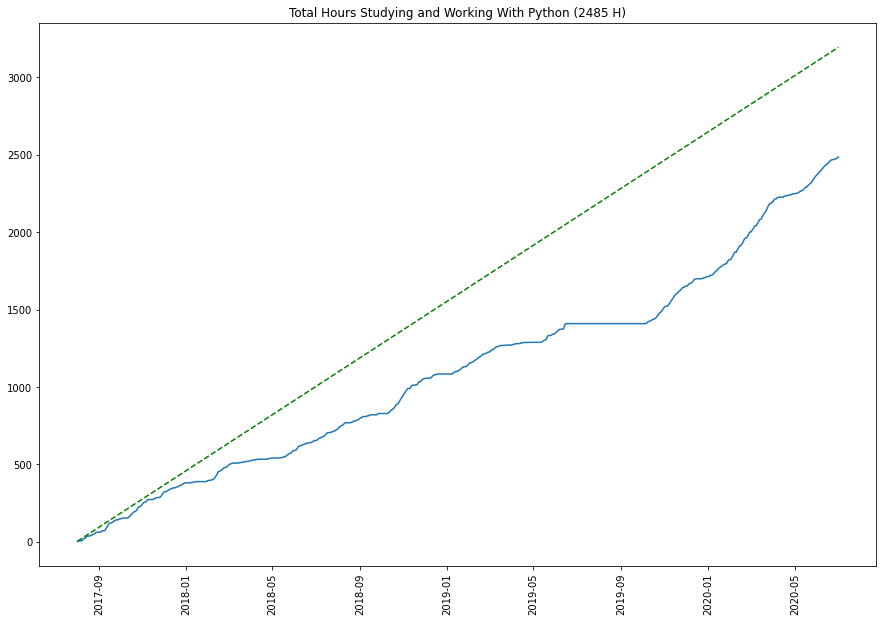

In [8]:
practice_plot(rs_df)

#Current Year Analysis

In [9]:
#we create a copy in order to modify without 
#corrupting the original df
#containing all the records 
#of the selected activity
#grouped by day 
pythondf=rs_df
#this is a test for timeseries slicing
print("Test_selezione \n", pythondf['2020'].tail())
print(pythondf.head())
print(pythondf.index[1:10])
#here you can put automatically the year
select_Year='2020'
start=-365
print(len(pythondf.iloc[start:]))

Test_selezione 
             Year  Month   Day  Time  ...   End  Activity     Cum  Costant_CUM
Date                                 ...                                     
2020-06-27   0.0    0.0   0.0   0.0  ...   0.0       0.0  2472.5         3183
2020-06-28   8.0    8.0   8.0   8.0  ...   8.0       8.0  2476.5         3186
2020-06-29   4.0    4.0   4.0   4.0  ...   4.0       4.0  2478.5         3189
2020-06-30  11.0   11.0  11.0  11.0  ...  11.0      11.0  2484.0         3192
2020-07-01   2.0    2.0   2.0   2.0  ...   2.0       2.0  2485.0         3195

[5 rows x 10 columns]
            Year  Month  Day  Time  ...  End  Activity  Cum  Costant_CUM
Date                                ...                                 
2017-08-02   2.0    2.0  2.0   2.0  ...  2.0       2.0  1.0            3
2017-08-03   2.0    2.0  2.0   2.0  ...  2.0       2.0  2.0            6
2017-08-04   5.0    5.0  5.0   5.0  ...  5.0       5.0  4.5            9
2017-08-05   2.0    2.0  2.0   2.0  ...  2.0     

In [10]:

tot_hours=rs_df[select_Year]['Costant_CUM'][-1]-rs_df[select_Year]['Costant_CUM'][0]
average=(tot_hours/365/2).round(2)

print((tot_hours/2).round(2))
print(average,'\n')



273.0
0.75 



#-365 Plot 

Max Hours 2485 h
Il differenziale assoluto è di -710.0 ore

 La percentuale di cambiamento è di 97.13 negli ultimi -30 giorni 

 La percentuale di cambiamento è di 99.58 negli ultimi -90 giorni 

 La percentuale di cambiamento è di 75.73 negli ultimi -180 giorni 


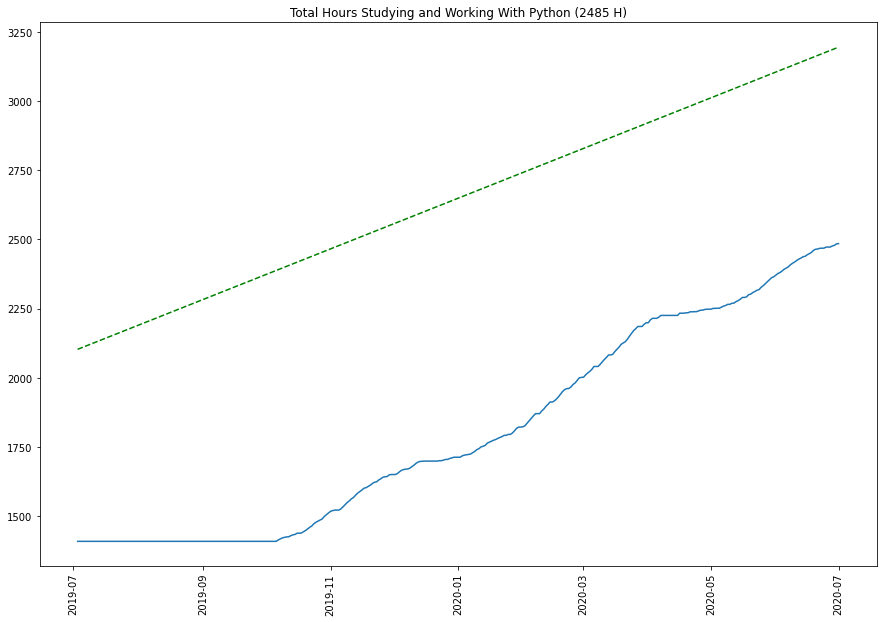

In [11]:
practice_plot(rs_df.iloc[start:])

#Current Year Analysis 

In [12]:
#we create a 
#current day vector 
#current month vector (int)
#current year vector (int)
today=datetime.now()
actual_month=today.month
actual_year=today.year
print(type(actual_year))

#we convert to string 
#current year vector 
year_str=str(actual_year)
d=1
#we create
#a starting point 
#for current year  
date2=datetime(actual_year,1,1)

#we create a 
#current month threshold 
filtering_threshold=datetime(actual_year,actual_month,d)
#we filter 
#the python activities df
#based on the current month 
python_act_m=pythondf[pythondf.index>=filtering_threshold]
#we filter 
#the python activities df
#based on the current year
python_act_y=pythondf[pythondf.index>=year_str]
#we calculate
#the numbers of days 
#from
#the beginning of the month 
#and the current day 
d_day=(today-filtering_threshold).days
#we calculate
#the numbers of days 
#from
#the beginning of the year
#and the current day 
d_y_day=(today-date2).days

print('Python monthly head \n', python_act_m.head())
print('Python yearly head \n', python_act_y.head())


<class 'int'>
Python monthly head 
             Year  Month  Day  Time  ...  End  Activity     Cum  Costant_CUM
Date                                ...                                    
2020-07-01   2.0    2.0  2.0   2.0  ...  2.0       2.0  2485.0         3195

[1 rows x 10 columns]
Python yearly head 
             Year  Month   Day  Time  ...   End  Activity     Cum  Costant_CUM
Date                                 ...                                     
2020-01-01   0.0    0.0   0.0   0.0  ...   0.0       0.0  1713.0         2649
2020-01-02   0.0    0.0   0.0   0.0  ...   0.0       0.0  1713.0         2652
2020-01-03  10.0   10.0  10.0  10.0  ...  10.0      10.0  1718.0         2655
2020-01-04   5.0    5.0   5.0   5.0  ...   5.0       5.0  1720.5         2658
2020-01-05   3.0    3.0   3.0   3.0  ...   3.0       3.0  1722.0         2661

[5 rows x 10 columns]


Max Hours 2485 h
Il differenziale assoluto è di -710.0 ore

 La percentuale di cambiamento è di 97.13 negli ultimi -30 giorni 

 La percentuale di cambiamento è di 99.58 negli ultimi -90 giorni 

 La percentuale di cambiamento è di 75.73 negli ultimi -180 giorni 


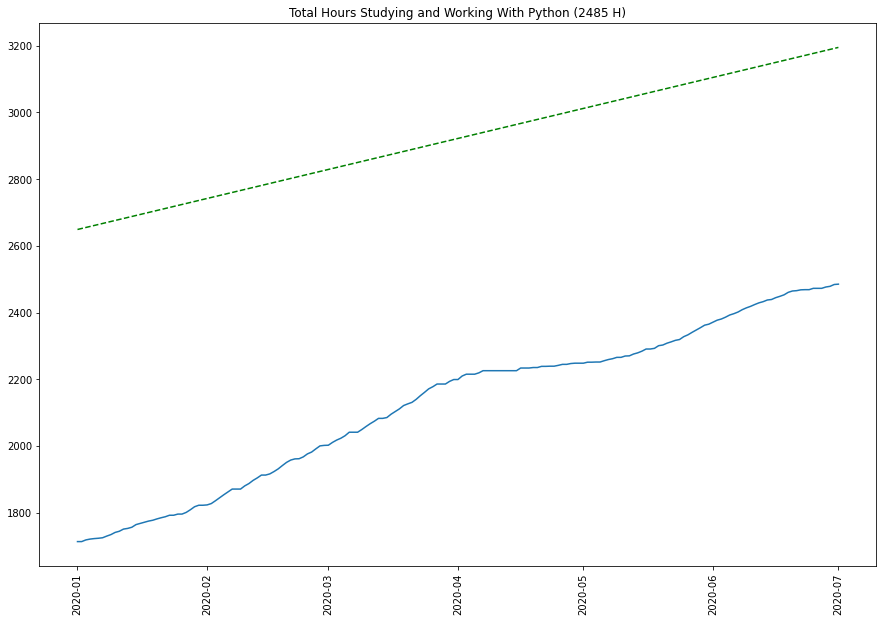

In [13]:
practice_plot(python_act_y)

Max Hours 2485 h


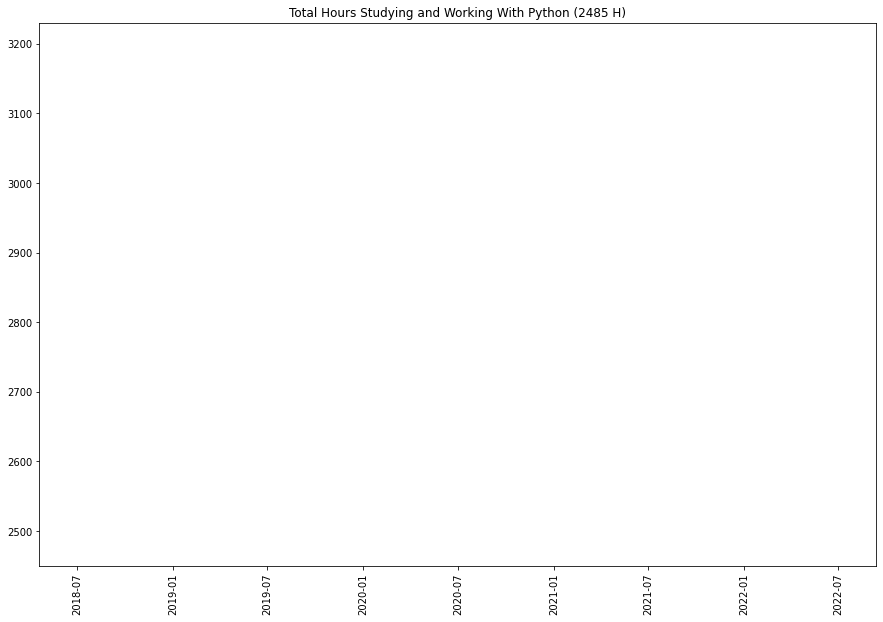

In [14]:
m_practice_plot(python_act_m)

In [15]:
#This is a relative plot in order 
#to analyze the learning trend 
#relative to 
#the current year 
#current month 
def relative_plot(df,date): 
    f_df=df[date::].copy()
    f_df['R_Cum']=f_df['Activity'].cumsum().divide(2)
    

    
    f_df['R_Costant_CUM']=np.arange(3,len(f_df)*3+1,3)

    maxh=f_df.R_Cum.max()
    maxc=f_df.R_Costant_CUM.max()
    
    print("Lo studio di Python Da",date," è di %s h"%maxh)

    delta=maxh-maxc
    print("\n Il differenziale relativo è di %s ore"%delta)
    
    fig, ax= plt.subplots()
    ax.plot(f_df.index,f_df['R_Cum'])
    ax.plot(f_df.index,f_df['R_Costant_CUM'],'g--')
    ax.tick_params(axis='x',rotation=90)
    ax.set(title='Relative Hours Studying and Working With Python (%d H)'%(maxh))
    
    plt.show()
    return 

Lo studio di Python Da 2020  è di 772.0 h

 Il differenziale relativo è di 223.0 ore


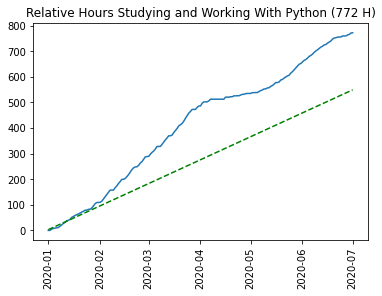

In [16]:
year='2020'
relative_plot(rs_df,year)

In this section we analyze how we are performing on monthly basis and on yearly basis
We should select manually the month and the year, this way is also possible to go back to any month 

In [17]:
month='2020-03'

Lo studio di Python Da 2020-03  è di 483.5 h

 Il differenziale relativo è di 114.5 ore


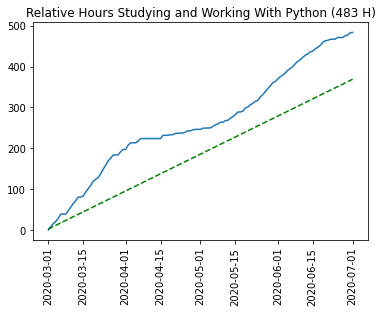

Max Hours 2485 h


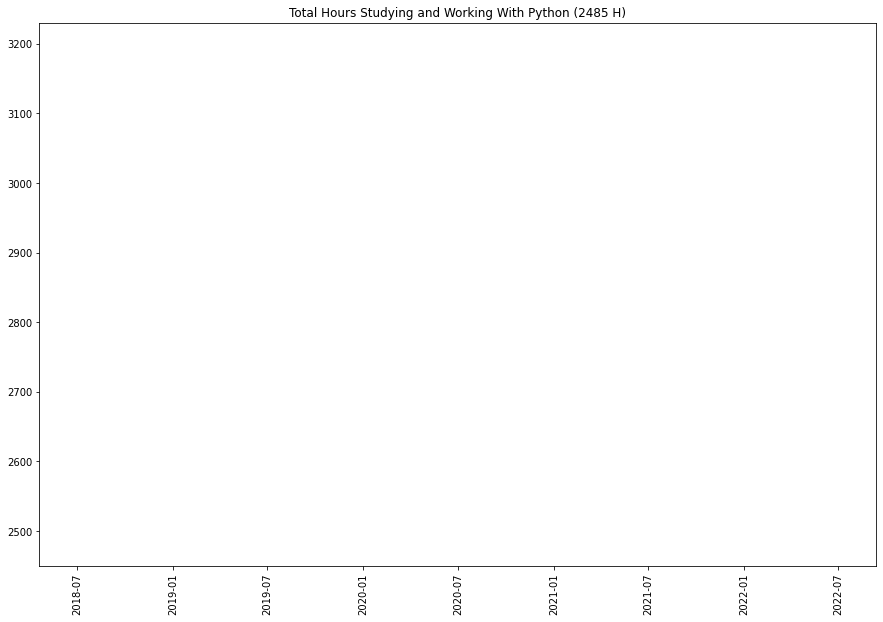

In [18]:
relative_plot(rs_df,month)
m_practice_plot(python_act_m)

Max Hours 2485 h
Il differenziale assoluto è di -710.0 ore

 La percentuale di cambiamento è di 97.13 negli ultimi -30 giorni 

 La percentuale di cambiamento è di 99.58 negli ultimi -90 giorni 

 La percentuale di cambiamento è di 75.73 negli ultimi -180 giorni 


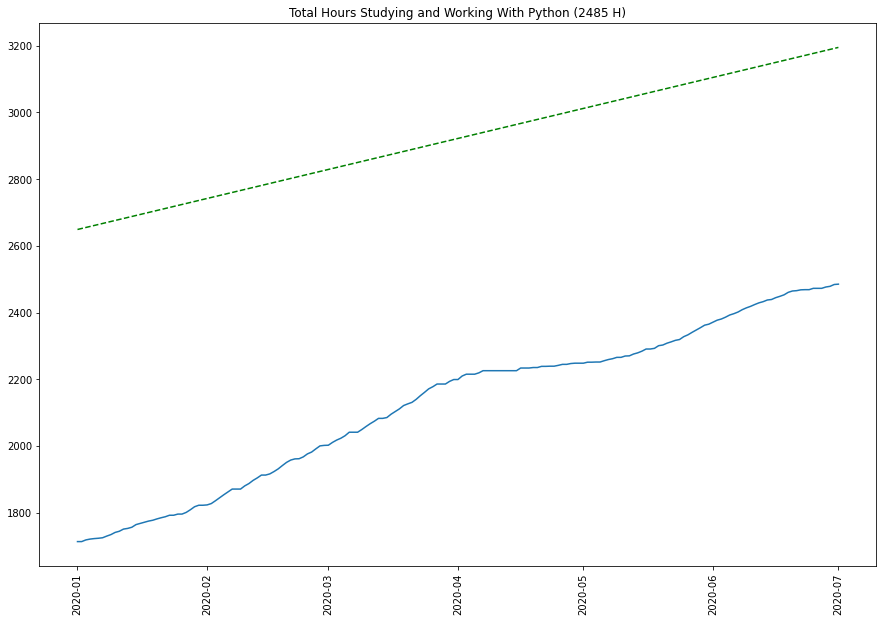

Lo studio di Python Da 2020  è di 772.0 h

 Il differenziale relativo è di 223.0 ore


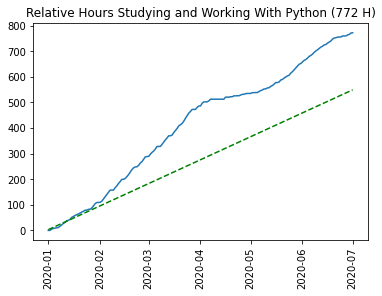

In [19]:
practice_plot(python_act_y)
relative_plot(rs_df,year)

Da questa sezione iniziamo a valutare ed identiicare la stazionarietà delle nostre serie storiche per poter predire l'opportuno risultato di ore che verranno dedicate nel futuro 

In [20]:
activity_divided=rs_df.Activity.divide(2)
print(activity_divided.mean())
print(activity_divided.std())
print(activity_divided.median())
print(activity_divided.describe())

2.3333333333333335
2.7999843357957754
1.5
count    1065.000000
mean        2.333333
std         2.799984
min         0.000000
25%         0.000000
50%         1.500000
75%         4.000000
max        16.000000
Name: Activity, dtype: float64


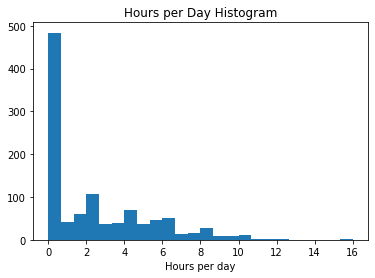

In [21]:
fig, ax=plt.subplots()
ax.hist(activity_divided,bins=24)
ax.set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.show()

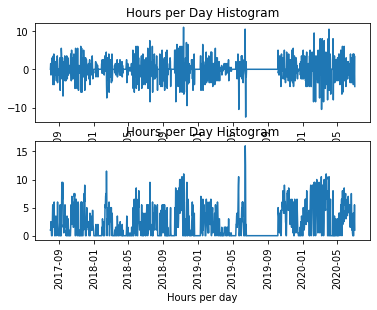

In [22]:
#we try to analyze the difference between days in order to see ho day change 
diff=activity_divided.diff().dropna()

fig, ax=plt.subplots(2,1)
ax[0].plot(diff.index,diff)
ax[0].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[0].get_xticklabels(),rotation=90)
ax[1].plot(activity_divided.index,activity_divided)
ax[1].set(xlabel='Hours per day',title='Hours per Day Histogram')
plt.setp(ax[1].get_xticklabels(),rotation=90)
plt.show()

Diff Summary Statistics: 
 count    1064.000000
mean        0.000000
std         2.628987
min       -12.500000
25%        -1.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: Activity, dtype: float64


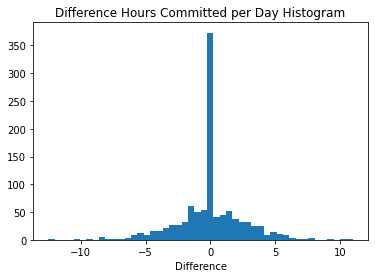

In [23]:
#here we plot the histogram of the difference in activity day 
print("Diff Summary Statistics: \n",diff.describe())
fig, ax=plt.subplots()
ax.hist(diff,bins=48)
ax.set(xlabel='Difference',title='Difference Hours Committed per Day Histogram')
plt.show()

In [24]:
#we create 
#a normal distribution 
#with 
#mean equal to the average hours per day 
#std is calculated also on daily basis
n_mean=rs_df.Activity.divide(2).mean()
n_std=rs_df.Activity.divide(2).mean()
n_obj=scipy.stats.norm(n_mean, n_std).cdf(n_mean)
print(n_obj)
pdf=[0.025, 0.25, 0.5,0.75, 0.975]
pdf2=[2, 25, 50,75, 97]
#for i in pdf2:
 #   print(i,scipy.stats.norm(n_mean, n_std).pdf(i)

          
normal_obj=np.random.normal(n_mean, n_std,1000)
normal_sorted=sorted(normal_obj)
percentile=[2.5,25,50, 75,97.5]
prc_array=np.percentile(normal_sorted,percentile)
print("percentile array \n", prc_array)
print(prc_array.size)
remaining_days=np.full(prc_array.size,remaining_h)
print("Year remaining to be an expert \n",(remaining_days/prc_array)/365)

0.5
percentile array 
 [-1.96988025  0.86123368  2.32060114  3.99319624  6.9588587 ]
5
Year remaining to be an expert 
 [-10.45192523  23.90645128   8.87228774   5.15603037   2.95868072]


Alcune risorse in merito alla:
1) Distribuzione Normale

2) Distribuzione Beta 

3) Distribuzione PERT 

https://www.vosesoftware.com/riskwiki/Beta4distribution.php

https://it.wikipedia.org/wiki/Distribuzione_Beta

https://en.wikipedia.org/wiki/PERT_distribution

https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy

https://medium.com/w2hds/beta-distribution-what-when-how-c5ebaafdeedd

https://bizfluent.com/how-6722338-calculate-pert.html

https://math.stackexchange.com/questions/521575/difference-between-probability-and-probability-density

In [25]:
#in this section we identify autocorrelation for our time series
#
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [26]:
#Try to approximate the actual curve with polynomial features 
#Is a trivial way to make a prediction 
#Just for practice
#not for pratical use 
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller

In [27]:
print(rs_df.head(5))
print(today)

            Year  Month  Day  Time  ...  End  Activity  Cum  Costant_CUM
Date                                ...                                 
2017-08-02   2.0    2.0  2.0   2.0  ...  2.0       2.0  1.0            3
2017-08-03   2.0    2.0  2.0   2.0  ...  2.0       2.0  2.0            6
2017-08-04   5.0    5.0  5.0   5.0  ...  5.0       5.0  4.5            9
2017-08-05   2.0    2.0  2.0   2.0  ...  2.0       2.0  5.5           12
2017-08-06   0.0    0.0  0.0   0.0  ...  0.0       0.0  5.5           15

[5 rows x 10 columns]
2020-07-03 15:22:18.775702


In [28]:
degree=1
model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
x=np.arange(0,len(rs_df.index))
x=x[:,np.newaxis]
y=np.array(rs_df['Cum'].values)
y=y[:,np.newaxis]
print(len(x))
print(len(rs_df['Cum']))
print(len(x),x.shape)
print(len(y),y.shape)
fitted=model.fit(x,y)
x_pred=np.arange(0,len(rs_df.index)+365)
x_pred=x_pred[:,np.newaxis]
y_plot = model.predict(x_pred)
print(type(model))
print(type(fitted))
#we need to get another y pred 
#in order to evaluate 
#the residuals 
y_res=model.predict(x)
residuals=y_res-y
flat_residuals=residuals.flatten()
print(adfuller(flat_residuals))

1065
1065
1065 (1065, 1)
1065 (1065, 1)
<class 'sklearn.pipeline.Pipeline'>
<class 'sklearn.pipeline.Pipeline'>
(-1.174255383648933, 0.6845712137737741, 15, 1049, {'1%': -3.4365991650067502, '5%': -2.864299173128419, '10%': -2.5682390922672735}, 4613.842167288794)


In [29]:
#thorugh statsmodel ordinary least squared 
#we extract automatically residuals 
#and test if they are stationary or not 
import statsmodels.api as sm
#
X = sm.add_constant(x)
model_stat = sm.OLS(y,X)
results_stats = model_stat.fit()
print(results_stats.params)
#we test if residuals are stationary or not 
#with adfuller test
print(adfuller(results_stats.resid))

[-4.7246818   2.07640013]
(-1.1742553836489587, 0.6845712137737633, 15, 1049, {'1%': -3.4365991650067502, '5%': -2.864299173128419, '10%': -2.5682390922672735}, 4613.842167288792)


[2962.45110513]
[2.07]


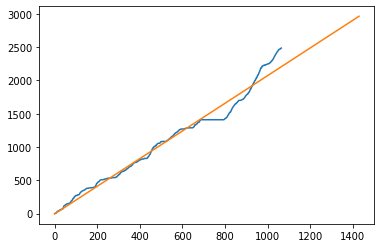

In [30]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x, y)
ax.plot(x_pred,y_plot)
print(y_plot[-1])
average=y_plot[-1]/len(y_plot)
print(np.round(average,2))

2.3333333333333335


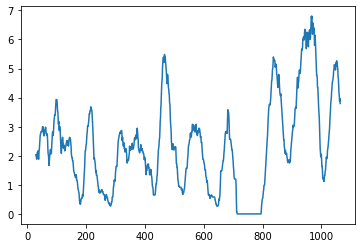

In [31]:
week_moving_average=rs_df.Activity.divide(2).rolling(window=30).mean()
mean_activity=rs_df.Activity.divide(2).mean()
print(mean_activity)
x_moving=np.arange(0,len(week_moving_average))
fig,ax=plt.subplots()
ax.plot(x_moving,week_moving_average)
plt.show()

In this section we try to undestand if the difference between daily records is stationary with ad adfuller test 

In [32]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(diff)

print(result[0])
print("Adfuller p value:\n",np.round(result[1],4))

-11.237423483755537
Adfuller p value:
 0.0


###### 